<a href="https://colab.research.google.com/github/sktoyo/colab-tutorial/blob/master/toy_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 개발환경 세팅

Library import

In [0]:
import os
import sys

import tensorflow as tf
from tensorflow.keras import layers
from tqdm.notebook import trange, tqdm

import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score

import scipy.sparse as sp
import numpy as np
import random

import datetime

## Tensorboard codes

In [0]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/ 

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Data preprocessing

In [0]:
def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape


def convert_sparse_matrix_to_sparse_tensor(inputs):
    coo = inputs.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    output = tf.SparseTensor(indices, coo.data.astype('float64'), coo.shape)
    output = tf.dtypes.cast(output, tf.float32)
    return output


def dropout_dense(x, drop_rate):
    return tf.nn.dropout(x, rate=drop_rate)


def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt)#.tocoo()
    return convert_sparse_matrix_to_sparse_tensor(adj_normalized)


def get_norm_terms(adj):
    pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
    norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)
    return pos_weight, norm


def data_split(adj, validation_rate,
               test_rate):  # get train set, validation set, test set, using upper triangle of adj matrix
    coords, values, shape = sparse_to_tuple(adj)
    test_num = int(len(values) * test_rate)
    validation_num = int(len(values) * validation_rate)

    # create positive set for train, validation, test from
    coords = coords.tolist()
    positive_set = np.array([coo for coo in coords if coo[0] < coo[1]])
    positive_idx = np.array([coo[0] * shape[0] + coo[1] for coo in positive_set])

    np.random.shuffle(positive_set)

    test_pos = positive_set[:test_num]
    valid_pos = positive_set[test_num:(test_num + validation_num)]
    train_edges = positive_set[(test_num + validation_num):]

    # create negative set for validation, test
    negative_idx_list = list()


    while len(negative_idx_list) < test_num + validation_num:
        i = random.randrange(shape[0])
        j = random.randrange(shape[0])
        if i < j:
            idx = i * shape[0] + j
            if idx not in positive_idx:
                negative_idx_list.append(idx)

    negative_idx = np.array(negative_idx_list)

    np.random.shuffle(negative_idx)
    test_neg = np.array([[idx // shape[0], idx % shape[0]] for idx in negative_idx[:test_num]])
    valid_neg = np.array(
        [[idx // shape[0], idx % shape[0]] for idx in negative_idx[test_num:(test_num + validation_num)]])

    data = np.ones(len(train_edges))

    # reconstruct train adjacency matrix
    adj_train = sp.csr_matrix((data, (train_edges[:, 0], train_edges[:, 1])), shape=adj.shape)
    adj_train = adj_train + adj_train.T

    return adj_train, train_edges, valid_pos, valid_neg, test_pos, test_neg

def get_roc_score(edges_pos, edges_neg, model, adj_orig):
  def sigmoid(x):
    return 1 /(1 + np.exp(-x))

  reconstucted = gae.reconstructed
  preds = []
  pos = []
  for e in edges_pos:
    preds.append(sigmoid(reconstucted[e[0],e[1]]))
    pos.append(adj_orig[e[0],e[1]])

  preds_neg = []
  neg = []
  for e in edges_neg:
    preds_neg.append(sigmoid(reconstucted[e[0],e[1]]))
    neg.append(adj_orig[e[0],e[1]])
  
  preds_all = np.hstack([preds, preds_neg])
  labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
  roc_score = roc_auc_score(labels_all, preds_all)
  ap_score = average_precision_score(labels_all, preds_all)

  return roc_score, ap_score

# Model

In [0]:
class GraphConvolutionSparse(layers.Layer):
    def __init__(self, input_dim, output_dim, dropout):
        super(GraphConvolutionSparse, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout = dropout

    def build(self, inputs):
        self.w = self.add_weight(shape=(self.input_dim, self.output_dim), initializer='GlorotNormal', trainable=True)

    def call(self, adj, inputs):
        x = inputs
        x = dropout_dense(x, self.dropout)
        x = tf.matmul(x, self.w)
        x = tf.sparse.sparse_dense_matmul(adj, x)
        outputs = tf.nn.leaky_relu(x)
        return outputs

In [0]:
class GraphConvolution(layers.Layer):
    def __init__(self, input_dim, output_dim, dropout):
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout = dropout

    def build(self, inputs):
        self.w = self.add_weight(shape=(self.input_dim, self.output_dim), initializer='GlorotNormal', trainable=True)

    def call(self, adj, inputs):
        x = inputs
        x = tf.nn.dropout(inputs, self.dropout)
        x = tf.matmul(x, self.w)
        x = tf.sparse.sparse_dense_matmul(adj, x)
        outputs = tf.nn.leaky_relu(x)
        return outputs

In [0]:
class InnerProductDecoder(layers.Layer):
    def __init__(self, dropout):
        super(InnerProductDecoder, self).__init__()
        self.dropout = dropout

    def call(self, inputs):
        x = tf.nn.dropout(inputs, self.dropout)
        x = tf.transpose(inputs)
        outputs = tf.matmul(inputs, x)
        return outputs

In [0]:
class GraphAutoEncoder(tf.keras.Model):
    def __init__(self, adj_orig, dropout, original_dim, intermediate_dim, latent_dim, name="GCNModel"):
        super(GraphAutoEncoder, self).__init__(name=name)
        self.dropout = dropout
        self.pos_weight, self.norm = get_norm_terms(adj_orig)
        self.adj_orig_tensor = tf.sparse.to_dense(convert_sparse_matrix_to_sparse_tensor(adj_orig))

        # layers
        self.graphconvolutionsparse = GraphConvolutionSparse(
            input_dim=original_dim,
            output_dim=intermediate_dim,
            dropout=self.dropout)
        self.graphconvolution = GraphConvolution(
            input_dim=intermediate_dim,
            output_dim=latent_dim,
            dropout=self.dropout)
        self.innerproductdecoder = InnerProductDecoder(
            dropout=self.dropout
        )

    def set_adj(self, adj):
        self.adj = adj

    def call(self, inputs):
        self.intermediate_latent = self.graphconvolutionsparse(self.adj, inputs)
        self.final_latent = self.graphconvolution(self.adj, self.intermediate_latent)
        self.reconstructed = self.innerproductdecoder(self.final_latent)

        # loss function
        loss = self.norm * tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=tf.reshape(self.reconstructed, [-1]),
                                                                          labels=tf.reshape(self.adj_orig_tensor, [-1]),
                                                                          pos_weight=self.pos_weight))

        self.add_loss(loss)

        # acc function
        correct_prediction = tf.equal(tf.cast(tf.greater_equal(tf.sigmoid(self.reconstructed), 0.5), tf.int32),
                                      tf.cast(self.adj_orig_tensor, tf.int32))
        acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        self.add_metric(acc, name='acc', aggregation='mean')

        return self.reconstructed

In [0]:
class validationCallback(tf.keras.callbacks.Callback):
  
  def __init__(self, input_dataset, val_pos, val_neg, adj_orig):
    super(validationCallback, self).__init__()

    self.val_pos = val_pos
    self.val_neg = val_neg
    self.adj_orig = adj_orig
    self.roc_scores = []
    self.ap_scores = []
  
  def on_epoch_end(self, epoch, logs=None):
    reconstructed = self.model.predict(input_dataset)
    preds = []
    pos = []
    for e in self.val_pos:
      preds.append(tf.keras.activations.sigmoid(reconstructed[e[0],e[1]]))
      pos.append(self.adj_orig[e[0],e[1]])

    preds_neg = []
    neg = []
    for e in self.val_neg:
      preds_neg.append(tf.keras.activations.sigmoid(reconstructed[e[0],e[1]]))
      neg.append(adj_orig[e[0],e[1]])
    
    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    self.roc_scores.append(roc_score)
    ap_score = average_precision_score(labels_all, preds_all)
    self.ap_scores.append(ap_score)
    print('\nEpoch %05d: validation roc %f, validation ap %f' % (epoch+1, roc_score, ap_score))

# Toy model

## Input data

In [0]:
# Toy graph
karate_G = nx.karate_club_graph()

karate_G = nx.karate_club_graph()
karate_adj = nx.adj_matrix(karate_G)

In [0]:
# Original Adjacency matrix
adj_orig = karate_adj
adj_orig_tensor = tf.sparse.to_dense(convert_sparse_matrix_to_sparse_tensor(adj_orig))

# Input feature matrix
feature_tensor = tf.eye(karate_adj.shape[0])
input_dataset = tf.data.Dataset.from_tensors(feature_tensor)

# Data split
adj_train, train_edges, valid_pos, valid_neg, test_pos, test_neg = data_split(adj_orig, 0.2, 0.1)

# Preporcess the adjacency matrix
adj_train = preprocess_graph(adj_train)

# Learning parameters
epochs = 100
input_layer_dim = int(adj_orig.shape[0])
first_layer_dim = 128
final_layer_dim = 64
dropout = 0

## Class model test

In [0]:
# Define model
gae = GraphAutoEncoder(adj_orig, 0, input_layer_dim, first_layer_dim, final_layer_dim)
gae.set_adj(adj_train)

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Compile model
gae.compile(optimizer)

# Define callbacks
validation_Callback = validationCallback(input_dataset, valid_pos, valid_neg, adj_orig)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Learning
history= gae.fit(x=input_dataset, epochs=epochs, callbacks=[callback, validation_Callback])


## Functional model test

In [0]:
# Define functional model
original_input = tf.keras.Input(shape=(feature_tensor.shape[0], feature_tensor.shape[1]))
first_latent = GraphConvolutionSparse(input_layer_dim, first_layer_dim, dropout)(adj_train, tf.reshape(original_input, shape=[feature_tensor.shape[0], feature_tensor.shape[1]]))
final_latent = GraphConvolution(first_layer_dim, final_layer_dim, dropout)(adj_train, first_latent)
reconstructed = InnerProductDecoder(dropout)(final_latent)

gae = tf.keras.Model(inputs = first_latent, outputs = reconstructed, name='gae')

# Add loss
loss = gae_loss(adj_orig, adj_orig_tensor, gae)
gae.add_loss(loss)

# Add acc
acc = gae_acc(adj_orig_tensor, gae)
gae.add_metric(acc, name='acc', aggregation='mean')

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Compile model
gae.complie(optimizer)

# Define callbacks
validation_Callback = validationCallback(input_dataset, valid_pos, valid_neg, adj_orig)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Learning
history= gae.fit(x=input_dataset, epochs=epochs, callbacks=[callback, validation_Callback])

## Visualization

In [0]:
%tensorboard --logdir logs/fit

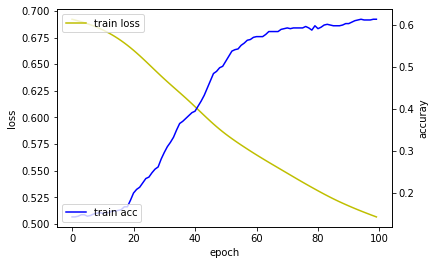

In [61]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
# loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
# acc_ax.plot(history.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [0]:
x = np.linspace(0, 2*np.pi, 400)
y = np.sin(x**2)

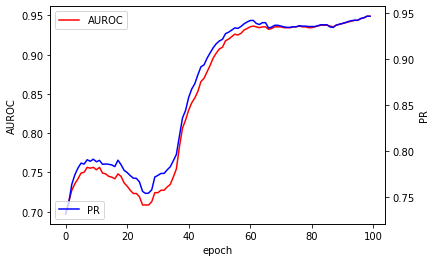

In [0]:
fig, auc_ax = plt.subplots()

pr_ax = auc_ax.twinx()
roc_scores = validation_Callback.roc_scores
ap_scores = validation_Callback.ap_scores

auc_ax.plot(roc_scores, 'r', label='AUROC')
# loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

pr_ax.plot(ap_scores, 'b', label='PR')
# acc_ax.plot(history.history['val_acc'], 'g', label='val acc')

auc_ax.set_xlabel('epoch')
auc_ax.set_ylabel('AUROC')
pr_ax.set_ylabel('PR')

auc_ax.legend(loc='upper left')
pr_ax.legend(loc='lower left')

plt.show()

# loss calculation

In [0]:
# loss function
def gae_loss(adj_orig, adj_orig_tensor, input_dataset, gae):
  pos_weight, norm = get_norm_terms(adj_orig)
  reconstructed = gae.predict(input_dataset)
  loss = norm * tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=tf.reshape(reconstructed, [-1]),
                                                                          labels=tf.reshape(adj_orig_tensor, [-1]),
                                                                          pos_weight=pos_weight))
  return loss

# acc function
def gae_acc(adj_orig_tensor, gae):
  correct_prediction = tf.equal(tf.cast(tf.greater_equal(tf.sigmoid(gae.reconstructed), 0.5), tf.int32),
                                      tf.cast(adj_orig_tensor, tf.int32))
  acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  return acc